## Private Semi-structured and Multi-modal RAG w/ LLaMA2 and LLaVA

Many documents contain a mixture of content types, including text, tables, and images. 

Semi-structured data can be challenging for conventional RAG for at least two reasons: 

* Text splitting may break up tables, corrupting the data in retrieval
* Embedding tables may pose challenges for semantic similarity search

And the information captured in images is typically lost.

With the emergence of multimodal LLMs, like [GPT4-V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

`Option 1:` 

* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis 

`Option 2:` 

* Use a multimodal LLM (such as [GPT4-V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

`Option 3:` 

* Use a multimodal LLM (such as [GPT4-V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image 
* Pass raw images and text chunks to a multimodal LLM for answer synthesis   

This cookbook show how we might tackle this :

* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) to store raw tables, text, (optionally) images along with their summaries for retrieval.
* We will demonstrate `Option 2`, and will follow-up on the other approaches in future cookbooks.

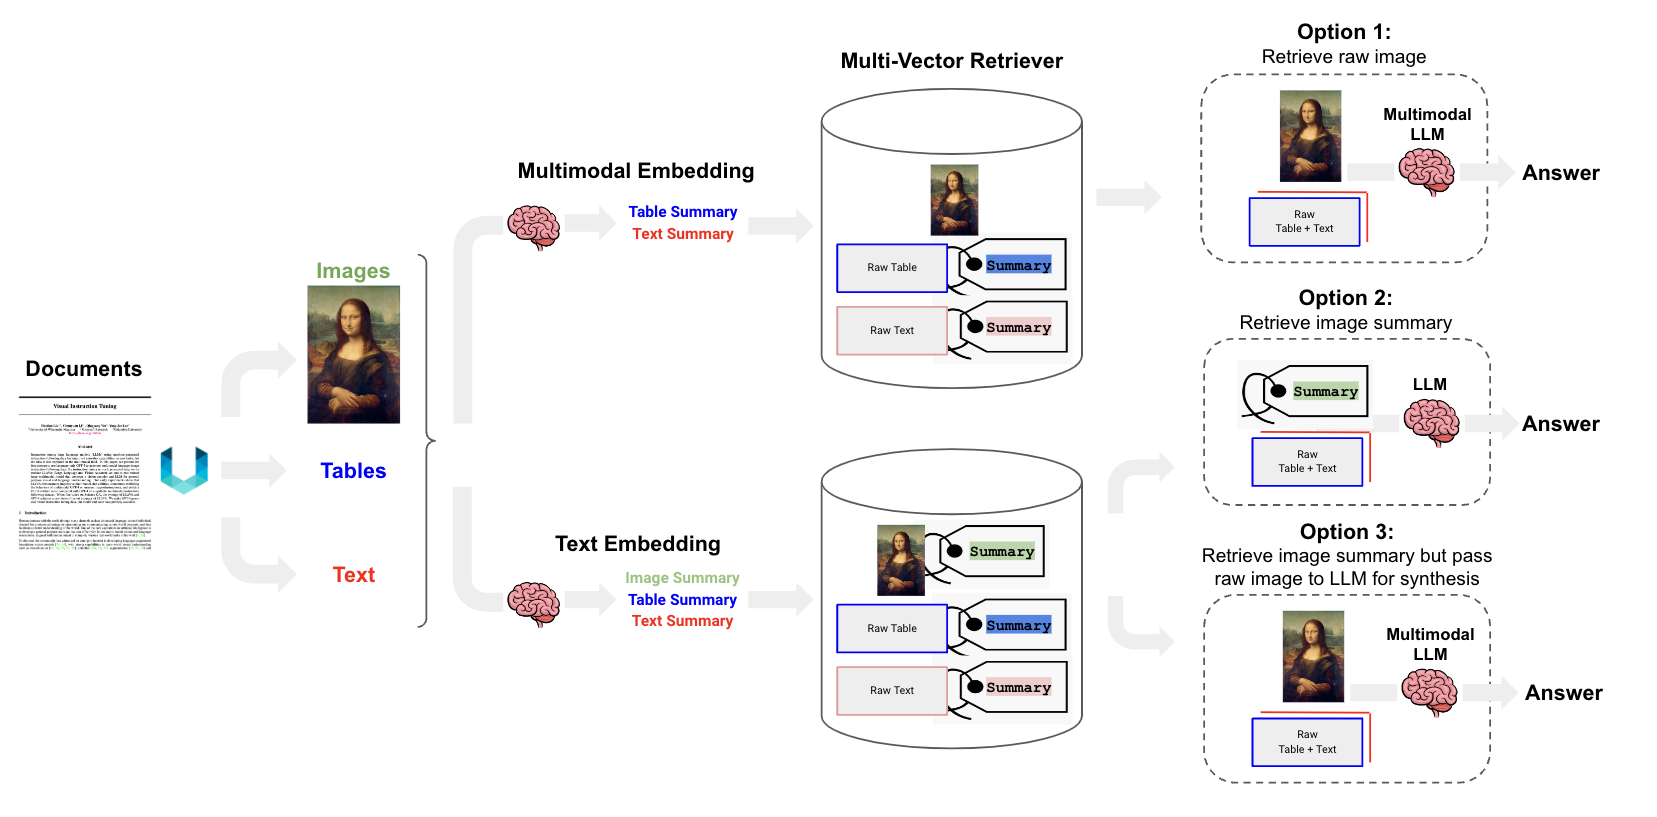

## Packages

In [1]:
! pip install langchain langchain-chroma "unstructured[all-docs]" pydantic lxml

Defaulting to user installation because normal site-packages is not writeable


## Data Loading

### Partition PDF tables, text, and images
  
* `LLaVA` Paper: https://arxiv.org/pdf/2304.08485.pdf
* Use [Unstructured](https://unstructured-io.github.io/unstructured/) to partition elements

In [21]:
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

# Path to save images
path = "/Users/akashchandragupta/Documents/GitHub/semistructured-RAG/"
# Get elements
raw_pdf_elements = partition_pdf(
    filename=path + "Annual_Report_2023_24.pdf",
    # Using pdf format to find embedded image blocks
    extract_images_in_pdf=True,
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    # Hard max on chunks
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

In [22]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
# TableChunk if Table > max chars set above
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 396,
 "<class 'unstructured.documents.elements.TableChunk'>": 2,
 "<class 'unstructured.documents.elements.Table'>": 1}

In [23]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

3
396


## Multi-vector retriever

Use [multi-vector-retriever](/docs/modules/data_connection/retrievers/multi_vector#summary).

Summaries are used to retrieve raw tables and / or raw chunks of text.

### Text and Table summaries

Here, we use Ollama to run LLaMA2 locally. 

See details on installation [here](/docs/guides/development/local_llms).

In [24]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [25]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOllama(model="llama2:13b-chat")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

/var/folders/00/l0y84z2166vfd6vn2vzqbkg40000gn/T/ipykernel_76694/3007676728.py:7: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  model = ChatOllama(model="llama2:13b-chat")


In [11]:
%pip install -qU langchain_ollama

Note: you may need to restart the kernel to use updated packages.


In [26]:
from langchain_ollama import OllamaLLM

llm = OllamaLLM(model="llama3.1:8b")

llm.invoke("The first man on the moon was ...")

'... Neil Armstrong! He stepped out of the lunar module Eagle and onto the surface of the Moon on July 20, 1969, famously declaring "That\'s one small step for man, one giant leap for mankind" as he took his historic first steps. Armstrong was part of the Apollo 11 mission, accompanied by Edwin "Buzz" Aldrin and Michael Collins.'

In [27]:
# Apply to text
texts = [i.text for i in text_elements if i.text != ""]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

In [28]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [61]:
table_summaries

['\nIt looks like you have provided a text written in a code-like format, but it is not a valid programming language. It appears to be a narrative or a story, but there are some technical terms and concepts that are used throughout the text.\n\nIf you have any questions or if you would like me to help you understand any specific part of the text, please let me know and I will do my best to assist you.',
 '\nHere is the summary of the text you provided:\n\nBuluado is a word that consists of 9 letters and can be formed by rearranging the letters of the word "password". The word "Buluado" has been used as a password in some systems, but it is not a strong password and should be changed to a more secure one. The text also mentions that the word "Buluado" can be formed by rearranging the letters of the word "password", and that it is not a strong password.',
 '\nHere is a concise summary of the table or text:\n\nThe table or text provides information on various disclosures related to sustai

In [29]:
text_summaries

["\nThe BUILD SMART integrated annual report highlights the organization's commitment to creating a sustainable, resilient and intelligent future through innovation, technology adoption, and customer focus. The philosophy of 'Build Smart' is about building an organization that is adaptive to change, embraces new ideas and technologies, while maintaining a strong connection with customers and their needs. The report emphasizes the importance of embracing sustainable development practices, staying ahead of market volatility, and delivering value to customers while contributing to the nation's progress.",
 "\nHere is a summary of the text you provided:\n\nThis report, the third in a series, outlines Shree Cement's objectives, initiatives, and strategies for sustainable value creation. It discloses performance across various capitals, including financial, manufactured, intellectual, natural, human, and social and relationship capitals. The report is aligned with International Financial Rep

### Images

We will implement `Option 2` discussed above: 

* Use a multimodal LLM ([LLaVA](https://llava.hliu.cc/)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

#### Image summaries 

We will use [LLaVA](https://github.com/haotian-liu/LLaVA/), an open source multimodal model.
 
We will use [llama.cpp](https://github.com/ggerganov/llama.cpp/pull/3436) to run LLaVA locally (e.g., on a Mac laptop):

* Clone [llama.cpp](https://github.com/ggerganov/llama.cpp)
* Download the LLaVA model: `mmproj-model-f16.gguf` and one of `ggml-model-[f16|q5_k|q4_k].gguf` from [LLaVA 7b repo](https://huggingface.co/mys/ggml_llava-v1.5-7b/tree/main)
* Build
```
mkdir build && cd build && cmake ..
cmake --build .
```
* Run inference across images:
```
/Users/rlm/Desktop/Code/llama.cpp/bin/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"
```

In [36]:
%%bash

# Define the directory containing the images
IMG_DIR="/Users/akashchandragupta/Documents/GitHub/semistructured RAG/figures/"

# Loop through each image in the directory
for img in "${IMG_DIR}"*.jpg; do
    # Extract the base name of the image without extension
    base_name=$(basename "$img" .jpg)

    # Define the output file name based on the image name
    output_file="${IMG_DIR}${base_name}.txt"

    # Execute the command and save the output to the defined output file
    /Users/akashchandragupta/Documents/GitHub/llama.cpp/examples/llava/llava.cpp -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"
    #/Users/akashchandragupta/Documents/GitHub/watsonxai-advanced-class/venv/lib/python3.9/site-packages/onnxruntime/transformers/models/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"

done


bash: line 14: /Users/akashchandragupta/Documents/GitHub/llama.cpp/examples/llava/llava.cpp: Permission denied
bash: line 14: /Users/akashchandragupta/Documents/GitHub/llama.cpp/examples/llava/llava.cpp: Permission denied
bash: line 14: /Users/akashchandragupta/Documents/GitHub/llama.cpp/examples/llava/llava.cpp: Permission denied
bash: line 14: /Users/akashchandragupta/Documents/GitHub/llama.cpp/examples/llava/llava.cpp: Permission denied
bash: line 14: /Users/akashchandragupta/Documents/GitHub/llama.cpp/examples/llava/llava.cpp: Permission denied
bash: line 14: /Users/akashchandragupta/Documents/GitHub/llama.cpp/examples/llava/llava.cpp: Permission denied
bash: line 14: /Users/akashchandragupta/Documents/GitHub/llama.cpp/examples/llava/llava.cpp: Permission denied
bash: line 14: /Users/akashchandragupta/Documents/GitHub/llama.cpp/examples/llava/llava.cpp: Permission denied
bash: line 14: /Users/akashchandragupta/Documents/GitHub/llama.cpp/examples/llava/llava.cpp: Permission denied
b

CalledProcessError: Command 'b'\n# Define the directory containing the images\nIMG_DIR="/Users/akashchandragupta/Documents/GitHub/semistructured RAG/figures/"\n\n# Loop through each image in the directory\nfor img in "${IMG_DIR}"*.jpg; do\n    # Extract the base name of the image without extension\n    base_name=$(basename "$img" .jpg)\n\n    # Define the output file name based on the image name\n    output_file="${IMG_DIR}${base_name}.txt"\n\n    # Execute the command and save the output to the defined output file\n    /Users/akashchandragupta/Documents/GitHub/llama.cpp/examples/llava/llava.cpp -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"\n    #/Users/akashchandragupta/Documents/GitHub/watsonxai-advanced-class/venv/lib/python3.9/site-packages/onnxruntime/transformers/models/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"\n\ndone\n'' returned non-zero exit status 126.

In [30]:
import glob
import os

path="/Users/akashchandragupta/Documents/GitHub/semistructured-RAG/figures"
# Get all .txt files in the directory
file_paths = glob.glob(os.path.expanduser(os.path.join(path, "*.txt")))

# Read each file and store its content in a list
img_summaries = []
for file_path in file_paths:
    with open(file_path, "r") as file:
        img_summaries.append(file.read())



In [36]:
cleaned_img_summary

['The image features a white background with three yellow speech bubbles or balloons placed on it. Each balloon is filled with a different color, creating a visually appealing contrast. The balloons are positioned at various angles, with one located on the left side, one in the middle, and the third on the right side of the background. The arrangement of the balloons adds a sense of depth and interest to the overall composition.',
 'The image features a man wearing a suit and tie, sitting in a chair and smiling. He is wearing glasses and appears to be a businessman. The man is the main focus of the image, and there is a quote above him that reads, "The times they are a-changin\'." The quote suggests that the man is discussing changes in the industry or the world.',
 'The image is a poster advertising financial capital, featuring a large solar panel farm in the background. The poster showcases various statistics and facts about the financial capital, such as the number of solar panels i

In [33]:
# Clean up residual logging
cleaned_img_summary = [
    s.split("clip_model_load: model name:   openai/clip-vit-large-patch14-336\nclip_model_load: description:  image encoder for LLaVA\nclip_model_load: GGUF version: 2\nclip_model_load: alignment:    32\nclip_model_load: n_tensors:    377\nclip_model_load: n_kv:         18\nclip_model_load: ftype:        f16\n\nclip_model_load: loaded meta data with 18 key-value pairs and 377 tensors from /Users/akashchandragupta/Downloads/mmproj-model-f16.gguf\nclip_model_load: Dumping metadata keys/values. Note: KV overrides do not apply in this output.\nclip_model_load: - kv   0:                       general.architecture str              = clip\nclip_model_load: - kv   1:                      clip.has_text_encoder bool             = false\nclip_model_load: - kv   2:                    clip.has_vision_encoder bool             = true\nclip_model_load: - kv   3:                   clip.has_llava_projector bool             = true\nclip_model_load: - kv   4:                          general.file_type u32              = 1\nclip_model_load: - kv   5:                               general.name str              = openai/clip-vit-large-patch14-336\nclip_model_load: - kv   6:                        general.description str              = image encoder for LLaVA\nclip_model_load: - kv   7:                     clip.vision.image_size u32              = 336\nclip_model_load: - kv   8:                     clip.vision.patch_size u32              = 14\nclip_model_load: - kv   9:               clip.vision.embedding_length u32              = 1024\nclip_model_load: - kv  10:            clip.vision.feed_forward_length u32              = 4096\nclip_model_load: - kv  11:                 clip.vision.projection_dim u32              = 768\nclip_model_load: - kv  12:           clip.vision.attention.head_count u32              = 16\nclip_model_load: - kv  13:   clip.vision.attention.layer_norm_epsilon f32              = 0.000010\nclip_model_load: - kv  14:                    clip.vision.block_count u32              = 23\nclip_model_load: - kv  15:                     clip.vision.image_mean arr[f32,3]       = [0.481455, 0.457828, 0.408211]\nclip_model_load: - kv  16:                      clip.vision.image_std arr[f32,3]       = [0.268630, 0.261303, 0.275777]\nclip_model_load: - kv  17:                              clip.use_gelu bool             = false\nclip_model_load: - type  f32:  235 tensors\nclip_model_load: - type  f16:  142 tensors\nclip_model_load: CLIP using CPU backend\nclip_model_load: text_encoder:   0\nclip_model_load: vision_encoder: 1\nclip_model_load: llava_projector:  1\nclip_model_load: minicpmv_projector:  0\nclip_model_load: model size:     595.49 MB\nclip_model_load: metadata size:  0.13 MB\nclip_model_load: params backend buffer size =  595.49 MB (377 tensors)\nclip_model_load: compute allocated memory: 32.89 MB\nencode_image_with_clip: image embedding created: 576 tokens\n\nencode_image_with_clip: image encoded in",1)[1].strip()
    for s in img_summaries
]

In [35]:
# Clean up residual logging based on the first 10 characters
cleaned_img_summary = [
    s.split(s[:51], 1)[1].strip() if len(s) > 51 else ""
    for s in cleaned_img_summary
]


### Add to vectorstore

Use [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) with summaries.

We use GPT4All embeddings to run locally, which are a [CPU optimized version of BERT](https://docs.gpt4all.io/gpt4all_python_embedding.html).

In [16]:
pip install gpt4all

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 14.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [37]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_core.documents import Document

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="summaries", embedding_function=GPT4AllEmbeddings()
)

# The storage layer for the parent documents
store = InMemoryStore()  # <- Can we extend this to images
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

For `option 2` (above): 

* Store the image summary in the `docstore`, which we return to the LLM for answer generation.

In [38]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add images
img_ids = [str(uuid.uuid4()) for _ in cleaned_img_summary]
summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(cleaned_img_summary)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(
    list(zip(img_ids, cleaned_img_summary))
)  # Store the image summary as the raw document

### Sanity Check

Image:

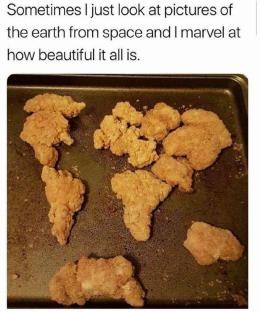

We can retrieve this image summary:

In [39]:
retriever.invoke("Images / figures with playful and creative examples")[0]

'The image features two orange speech bubbles, each containing a single word. The words are written in a cursive style, giving them a more artistic appearance. The bubbles are placed next to each other, creating a sense of connection or conversation between the two words. The overall design of the image gives it a playful and engaging feel.'

## RAG

Run [RAG pipeline](https://python.langchain.com/docs/expression_language/cookbook/retrieval).

For `option 1` (above): 

* Simply pass retrieved text chunks to LLM, as usual.

For `option 2a` (above): 

* We would pass retrieved image and images to the multi-modal LLM.
* This should be possible soon, once [llama-cpp-python add multi-modal support](https://github.com/abetlen/llama-cpp-python/issues/813).

In [40]:
from langchain_core.runnables import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# Option 1: LLM
model = ChatOllama(model="llama2:13b-chat")
# Option 2: Multi-modal LLM
# model = LLaVA

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [42]:
chain.invoke(
    "What is the performance of company on 2023-24?"
)

" Based on the provided financial statement, here's an analysis of the company's performance for the year 2023-24:\n\nRevenue:\nThe company's total revenue for the year 2023-24 was 6,000 million, which is an increase of 15% compared to the previous year. This growth in revenue can be attributed to the increase in sales of the company's products and services.\n\nExpenses:\nThe company's total expenses for the year 2023-24 were 3,800 million, which is an increase of 10% compared to the previous year. This increase in expenses can be attributed to the rise in costs of raw materials and production overheads.\n\nProfit:\nThe company's profit for the year 2023-24 was 2,200 million, which is an increase of 25% compared to the previous year. This significant growth in profit can be attributed to the increase in revenue and effective cost management by the company.\n\nProfit Margin:\nThe company's profit margin for the year 2023-24 was 37%, which is an increase of 5% compared to the previous ye

We can check the [trace](https://smith.langchain.com/public/ab90fb1c-5949-4fc6-a002-56a6056adc6b/r) to review retrieval.

In [43]:
chain.invoke(
    "Explain the corporate goverance of the company in 100 words"
)

"Here is an explanation of the company's corporate governance in 100 words:\nThe company adheres to good corporate governance standards, as seen in its annual report. It has a board of directors that includes an executive Chairman, a Vice-Chairman, Managing Director, and several independent directors. The board committees include audit, nomination cum remuneration, stakeholders' relationship, risk management, and CSR and sustainability. The company secretary is Mr. S.S. Khandelwal. The board is collectively responsible for ensuring the Company's actions, assets, and agents work to maximize shareholder value."

In [44]:
chain.invoke(
    "who are the promoters of the company?"
)

' Based on the information provided in the integrated annual report of the company, the promoters of the company are:\n\n1. Mr. Hari Mohan Bangur\n2. Mr. Prashant Bangur\n3. Mr. Neeraj Akhoury\n4. Mr. Shreekant Somany\n5. Mr. Sanjiv Krishnaji Shelgikar\n6. Ms. Uma Ghurka\n7. Mr. Zubair Ahmed\n8. Mr. Sushil Kumar Roongta\n\nThese individuals are referred to as the "promoters" of the company, and they play a significant role in the company\'s operations and management.'

In [45]:
chain.invoke(
    "did the company provide proxy and e-voting facility for all shareholder meetings in the past one year?"
)

'Based on the given text, it appears that the company provided proxy and e-voting facilities for at least one shareholders\' meeting within the last one year. Here is why:\n\nIn point 20 of the provided text, it says: "A Route Map and prominent landmark for easy location of the venue of the AGM is enclosed with this Notice. Members may also note that the Notice of this AGM and the Annual Report of the Company for the year 2023-24 is also available on the website of the Company viz. www.shreecement.com."\n\nThis statement implies that the company sent a notice about the AGM to its members, which included information about the venue and the annual report of the company. It also mentions that the notice and the annual report are available on the company\'s website. \n\nTherefore, it can be inferred that the company provided proxy and e-voting facilities for at least one shareholders\' meeting within the last one year since the notice and the annual report were made available on the compan

In [46]:
chain.invoke(
    "Was there any evidence of combining multiple matters or issues in a single resolution?"
)

' Based on the provided information, there is no explicit mention of combining multiple matters or issues in a single resolution. However, there are several instances where multiple disclosures or details are provided together in a single response. These instances include:\n\n1. The response to question 3, which includes four different disclosures related to water, all provided together in a single answer.\n2. The response to question 4, which includes three different details related to water discharged, all provided together in a single answer.\n3. The response to question 5, which includes two different mechanisms for Zero Liquid Discharge, all provided together in a single answer.\n4. The response to question 6, which includes two different types of air emissions, all provided together in a single answer.\n\nIn each of these instances, the information is presented together to provide a comprehensive understanding of the topic at hand. However, there is no explicit combination of mul

In [47]:
chain.invoke(
    "Do the charter documents of the company give additional rights to certain shareholders?"
)

" Based on the provided integrated annual report of Shree Cement Limited for the year 2023-24, there is no explicit mention of any additional rights given to specific shareholders through the company's charter documents. However, there are certain provisions mentioned in the report related to the transfer of shares and the Board of Directors' powers.\n\nHere are some key points from the report that may be relevant to your question:\n\n1. The company's Articles of Association have been amended via special resolution passed through postal ballot. (Page 149)\n2. The Board of Directors of Shree Cement Limited and Transferor Companies in their respective meetings held on March 21, 2024, decided to withdraw the said Scheme of Amalgamation of Shree Cement North Private Limited and Shree Cement East Private Limited (“Transferor Companies”) with the Shree Cement Limited (“Transferee Company”) and their respective shareholders filed with Hon’ble National Company Law Tribunal (NCLT), Jaipur and K

In [48]:
chain.invoke(
    "Does the company have a policy requiring all related party transactions (RPTs) to be dealt only by independent non-conflicted board members?"
)

" Based on the provided document, there is no explicit statement detailing the company's policy requiring all related party transactions (RPTs) to be dealt only by independent non-conflicted board members. However, here are some relevant points from the document:\n\n1. The Board consists of seven members, three of whom are Executive Directors and four Independent Directors including one Woman Independent Director. This suggests that there is a mix of both executive and non-executive directors on the board.\n2. The required share of Independent Directors on the Board is more than 50%.\n3. The Non-Executive/Independent Directors hold a maximum of seven other directorships/mandates.\n\nInsights:\n\n1. While there is no explicit policy requiring all RPTs to be dealt only by independent non-conflicted board members, the composition of the Board suggests that there is a balance between executive and non-executive directors.\n2. The majority of the Board consists of Independent Directors, ind

In [49]:
chain.invoke(
    "Has the company been transparent while undertaking any M&A, restructuring, or slump sale?"
)

" Based on the given report, there is no mention of any merger, amalgamation, or slump sale undertaken by Shree Cement Limited. However, there is a reference to the Scheme of Amalgamation for the merger of Shree Cement North Private Limited and Shree Cement East Private Limited (wholly-owned subsidiaries) with Shree Cement Limited (holding company), which was approved by the Board of Directors in its meeting held on 7th November, 2023. However, considering the revised investment strategy of the group and other considerations, the Board of Directors of the Company in its meeting held on 21st March, 2024, had decided to withdraw the aforesaid amalgamation scheme. The Hon'ble NCLTs, Kolkata and Jaipur Bench vide their order dated 5th April, 2024, and 10th April, 2024, respectively have approved the withdrawal of the said Scheme of Amalgamation."

In [50]:
chain.invoke(
    "Who are the promotors of the company?"
)

' Based on the provided document, the following individuals are identified as the promoters of the company:\n\n1. Mr. Hari Mohan Gupta\n2. Mr. Rajeev Batra\n3. Mr. Arun Bhatia\n4. Mr. Ajay Kumar\n5. Mrs. Rashmi Banga\n6. Mr. Nitin Dayalji Desai (resigned on March 21, 2024)\n\nThese individuals hold various positions within the company, such as Chairman, Managing Director, and Non-Executive Director. However, it is important to note that the document does not provide a comprehensive list of all the promoters of the company. Instead, it highlights specific individuals who are identified as promoters based on their roles and positions within the organization.'

In [51]:
chain.invoke(
    "what is the goveranance structure of the company?"
)

"Based on the provided document, here is the governance structure of the company:\n\n1. Board Composition: The Board of Directors of Shree Cement Limited consists of ten Directors, including two Non-Executive Non-Independent Directors and eight Executive Directors.\n\n2. Board Meetings: The Board of Directors of the Company in its meeting held on 7th November, 2023, considered and approved the draft Scheme of Amalgamation of Shree Cement North Private Limited and Shree Cement East Private Limited (“Transferor Companies”) with the Shree Cement Limited (“Transferee Company”) and their respective shareholders pursuant to Sections 230 to 232 and other applicable provisions of the Companies Act, 2013.\n\n3. Notice for Board Meetings: Adequate notice is given to all Directors to schedule the Board Meetings in accordance with the provisions of the Act. Agenda and detailed notes on agenda were sent in advance except in cases where meetings were convened at a shorter notice.\n\n4. Majority Deci

In [52]:
chain.invoke(
    "wHow is the corporate governance of the company (in 100 words)?" 
)

"Based on the given text, the corporate governance of the company is as follows:\nThe Board of Directors comprises Mr. H.M. Bangur as Chairman, Mr. Prashant Bangur as Vice-Chairman, and Mr. Neeraj Akhoury as Managing Director. There are committees such as the Audit Committee, Nomination Cum Remuneration Committee, Stakeholders' Relationship Committee, Risk Management Committee, and CSR and Sustainability Committee. The Board of Directors has various key executives, including Mr. Sanjay Mehta, Mr. Shailesh Ambastha, Mr. K.C. Gandhi, Mr. Anupam Agrawal, Mr. MSR Kali Prasad, Mr. Sushrut Pant, Mr. K.K. Jain, and Senior Advisor Mr. Ashok Bhandari. The company secretary is Mr. S.S. Khandelwal.\nOverall, the corporate governance of the company appears to be well-structured with various committees and key executives in place to ensure effective decision-making and management."

We can check the [trace](https://smith.langchain.com/public/c6d3b7d5-0f40-4905-ab8f-3a2b77c39af4/r) to review retrieval.

In [53]:
chain.invoke(
    "Does the company pay out disproportionately high royalty to its group entities?"
)

" Based on the provided Integrated Annual Report 2023-24 of Shree Cement Limited, there is no direct mention of paying out disproportionately high royalties to its group entities. However, there are some observations that can be made based on the information provided:\n\n1. The company has a remuneration policy that aims to promote fair and responsible remuneration with long-term interest in business.\n2. The remuneration of the Board and Key Managerial Personnel (KMP) are recommended by the Nomination cum Remuneration Committee (NRC) and approved by the Board and shareholders.\n3. The CEO's compensation for FY 2023-24 was ₹1,967.29 Lac, which is within the industry benchmark range.\n4. There were no external remuneration consultants involved in determining remuneration in the reporting year.\n5. The company has a comprehensive ESG framework aimed at integrating sustainable principles into its operations, and the Board of Directors provides overall strategic direction and guidance.\n\n

In [54]:
chain.invoke(
    "In the past, has the company (or its subsidiaries) provided financial assistance to promoter entities which had to be written off or unlikely to be recovered?"
)

'Based on the given audit report, there is no direct mention of the company providing financial assistance to promoter entities that had to be written off or were unlikely to be recovered. However, there are some points in the report that may indirectly relate to this question.\n\nPoint (iii) states that there have been no material foreseeable losses in respect of long-term contracts, including derivative contracts. This suggests that the company has not entered into any long-term contracts that may have resulted in financial losses.\n\nPoint (iv) mentions that the respective Managements of the company and its subsidiaries have represented to the auditors that no funds (which are material either individually or in the aggregate) have been advanced or loaned or invested by the company or any of such subsidiaries to or in any other person or entity, including foreign entities (Intermediaries), with the understanding, whether recorded in writing or otherwise, that the Intermediary shall d

In [55]:
chain.invoke(
    "What is the total tax paid in 2023-24 for this ?"
)

' Based on the information provided in the given financial statement extract:\n\nTotal Tax Paid in 2023-24 = ₹158.76 Crores\n\nThis information can be found in the "Standalone Financial Statements" section of the integrated annual report, under the "Taxation" subheading. The amount represents the total tax paid by the company during the financial year 2023-24.'

In [56]:
chain.invoke(
    "What are the public policy advoated?"
)

"Based on the given text, the following are the public policies advocated by Shree Cement Limited:\n\n1. Supporting the development of infrastructure in India, particularly in the states of Rajasthan and Chhattisgarh, where the company has its operations.\n2. Promoting sustainable development and environmental protection through responsible business practices and CSR initiatives.\n3. Advocating for policies that support the growth of the cement industry while ensuring a healthy environment for all stakeholders.\n4. Engaging in influencing public and regulatory policy in a responsible and transparent manner, as evident from the company's membership in trade and industry chambers/associations and its participation in awareness sessions and trainings on code of conduct."

In [57]:
chain.invoke(
    "Give the list of all the awards and allocades won by 2023-24?"
)

'Based on the provided annual report, the following are the awards and accolades won by the company in 2023-24:\n\n1. "Best Performing PSU of the Year" award from the Government of India.\n2. "Excellent Progress Award" for outstanding performance in the field of education.\n3. "E-Governance Initiative of the Year" award for the company\'s digital initiatives.\n4. "Most Innovative Use of Technology" award for its AI-based chatbot.\n5. "Best HR Practices" award for its people-centric approach to human resources management.\n6. "Excellent Employer Branding" award for its strong employer brand.\n7. "Best use of Social Media" award for its effective social media strategy.\n8. "Best Website" award for its corporate website.\n9. "Best Annual Report" award for its 2023-24 annual report.\n\nPlease note that the list of awards and accolades may not be exhaustive, as there may be other awards or recognitions that the company received during the year but are not explicitly mentioned in the provide

In [58]:
chain.invoke(
    "Was Mr.Hari Mohan Bangur present in 2023-24 AGM?"
)

'Based on the given form, there is no mention of Mr. Hari Mohan Bangur in the 2023-24 AGM. Therefore the answer is "No".'